## Análise de satisfação de clientes de E-commerce

### Problema de Negócio
Nesse projeto, precisamos captar a satisfação dos clientes com base em suas avaliações numa plataforma de e-commerce. Compreender o sentimento por trás dos comentários ajudará a empresa identificar preferências, satisfações ou insatisfações dos clientes. Os insights obtidos podem ser usados para melhorar o serviço e a experiência do cliente.

### Importação de bibliotecas

In [60]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Ferramentas de PLN para processamento de texto
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Pacotes de modelagem de dados
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Importação e Análise Exploratória dos Dados

In [2]:
# Importando dados
df = pd.read_csv('olist_order_reviews_dataset.csv')

In [3]:
# Visualização geral
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Tamanho do dataset
df.shape

(99224, 7)

In [5]:
# Verificando valores nulos
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [6]:
# Verificando valores duplicados
# Não há valores duplicados
df.duplicated().sum()

0

### Pré-processamento dos dados
O conjunto de dados possui muitos valores nulos no título e no texto das avaliações. Precisaremos eliminar valores ausentes e redefinir o índice dos dados

In [8]:
# Separando título de avaliações e avaliações
review_data_title = df['review_comment_title']
review_data = df.drop(['review_comment_title'],axis=1)

In [9]:
# Eliminando valores nulos
review_data = review_data.dropna()
review_data_title = review_data_title.dropna()

In [10]:
# Exibindo títulos das avaliações após exclusão de nulos
review_data_title 

9                        recomendo
15                 Super recomendo
19         Não chegou meu produto 
22                           Ótimo
34                      Muito bom.
                   ...            
99192                            👍
99196           muito bom produto 
99197    Não foi entregue o pedido
99199              OTIMA EMBALAGEM
99200               Foto enganosa 
Name: review_comment_title, Length: 11568, dtype: object

In [11]:
# Exibindo avaliações após exclusão de nulos
review_data.head()

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01


In [12]:
# Reorganizando o index das avaliações
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


(40977, 6)

In [13]:
# Reorganizando o index dos títulos das avaliações
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(3)
review_data_title.shape

0                  recomendo
1            Super recomendo
2    Não chegou meu produto 
Name: review_comment_title, dtype: object

(11568,)

#### Conclusões
1. 41% dos clientes deixaram comentários em suas avaliações
2. Apenas 11% dos clientes deixaram comentários com títulos

Agora, iremos pré-processar as revisões e os títulos para visualização e modelagem

In [ ]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')

In [14]:
# Limpando os comentários, removendo stopwords
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    words = str(words)  # <-- garante que seja string
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = [l for l in lower_case if l not in stop_words]
    comments.append(' '.join(filtered_result))

In [15]:
comments[0:11]

['recebi bem antes prazo estipulado',
 'parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa',
 'aparelho eficiente site marca aparelho impresso desinfector chegar outro nome atualizar marca correta vez aparelho',
 'pouco travando valor ta boa',
 'vendedor confiável produto ok entrega antes prazo',
 'gostaria saber sempre recebi compra agora decpcionou',
 'péssimo',
 'loja nota',
 'obrigado atençao amim dispensada',
 'compra realizada facilmente entrega efetuada antes prazo dado produto começou usado presente problemas',
 'relógio bonito barato']

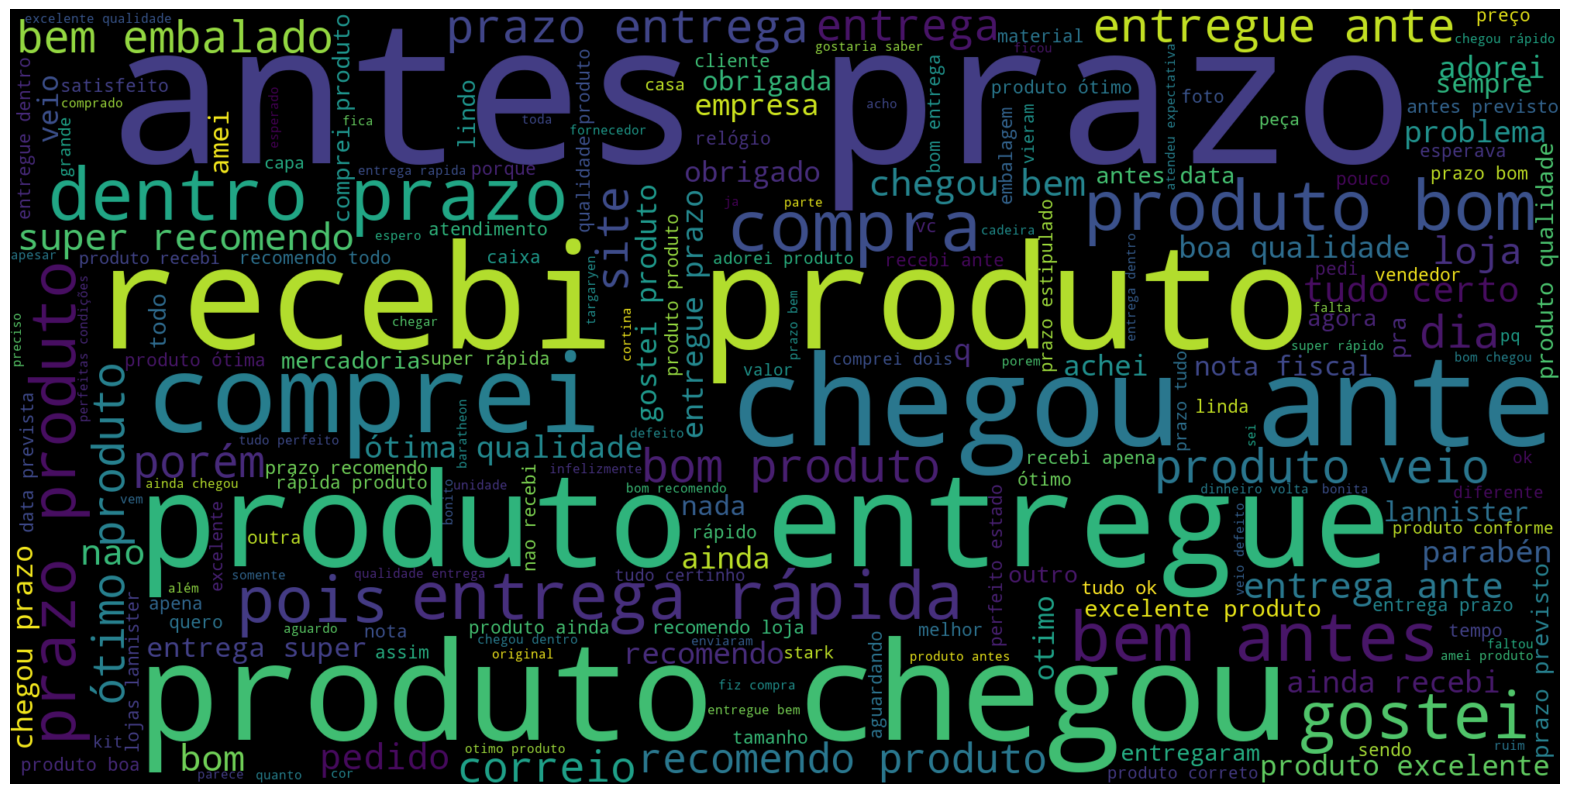

In [16]:
# Aplicando wordcloud para visualizar os dados
unique_string= (' ').join(comments)
wordcloud = WordCloud(width=2000, height=1000).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [17]:
# Usando CountVectorizer para pegar as palavras mais importantes
cv = CountVectorizer(ngram_range=(1,1))
counts = cv.fit_transform(comments)
important_unigrams = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False)
important_unigrams

,0
produto,18429
prazo,8475
entrega,6532
antes,5626
chegou,5555
...,...
fragia,1
fragiu,1
fragrâncias,1
fraldas,1


In [18]:
# Resentando o index
important_unigrams = important_unigrams.reset_index()
important_unigrams.rename(columns={'index':'unigrams', 0:'frequency'}, inplace=True)

In [19]:
# Usando o CountVectorizer para pegar os mais importantes trigrams
cv = CountVectorizer(ngram_range=(3,3))
counts = cv.fit_transform(comments)
important_trigrams = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False)

In [20]:
# Visualizando
important_trigrams

,0
chegou antes prazo,1142
bem antes prazo,706
entregue antes prazo,620
produto chegou antes,464
entrega antes prazo,441
...,...
entregou mercadoria antes,1
entregou mercadoria tempo,1
entregou metade pedido,1
entregou muiiiito rápido,1


In [22]:
# Resetando o index
important_trigrams = important_trigrams.reset_index()
important_trigrams.rename(columns={'index':'trigrams',0:'frequency'}, inplace=True)
important_trigrams

,trigrams,trigrams,frequency
0,0,chegou antes prazo,1142
1,1,bem antes prazo,706
2,2,entregue antes prazo,620
3,3,produto chegou antes,464
4,4,entrega antes prazo,441
...,...,...,...
161268,161268,entregou mercadoria antes,1
161269,161269,entregou mercadoria tempo,1
161270,161270,entregou metade pedido,1
161271,161271,entregou muiiiito rápido,1


#### Conclusões
De acordo com os unigramas e e trigramas, podemos afirmar que a maioria dos clientes ficou satisfeita com o serviço de entrega e qualidade dos produtos. Vamos nos aprofundar também nos clientes que não ficaram satisfeitos

In [24]:
# Verificando pontuações antes de remover os valores nulos
# Temos muitas avaliações ruins também (score = 1)
df['review_score'].value_counts()

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64

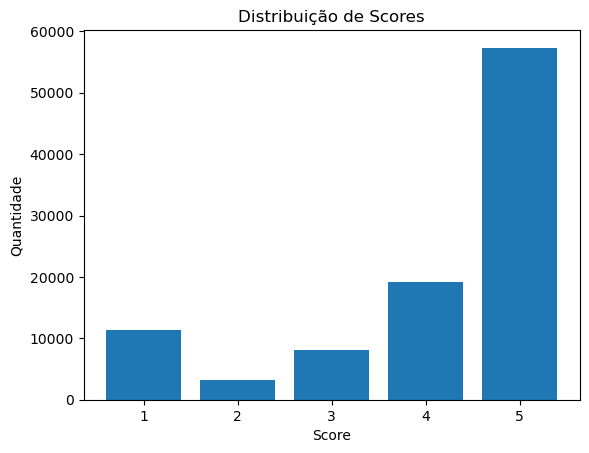

In [25]:
# Analisando graficamente a distribuição de score
contagem = df['review_score'].value_counts().sort_index()

# Gráfico simples
plt.bar(contagem.index, contagem.values)
plt.xlabel('Score')
plt.ylabel('Quantidade')
plt.title('Distribuição de Scores')
plt.show();

In [26]:
# Verificando pontuações depois de remover os valores nulos
review_data['review_score'].value_counts()

review_score
5    20554
1     8745
4     5976
3     3557
2     2145
Name: count, dtype: int64

In [37]:
# Checando a percentagem de score das avaliações
percent_scores = 100 * review_data['review_score'].value_counts()/len(review_data)
percent_scores

review_score
5    50.159846
1    21.341240
4    14.583791
3     8.680479
2     5.234644
Name: count, dtype: float64

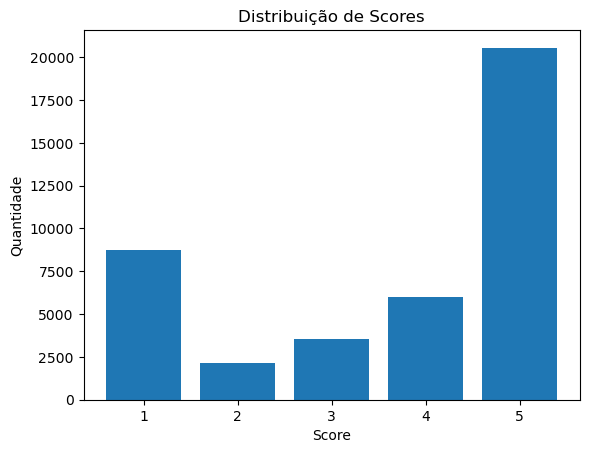

In [27]:
# Analisando graficamente a distribuição de score após remoção de valores nulos
contagem = review_data['review_score'].value_counts().sort_index()

# Gráfico simples
plt.bar(contagem.index, contagem.values)
plt.xlabel('Score')
plt.ylabel('Quantidade')
plt.title('Distribuição de Scores')
plt.show();

#### Conclusões
Após a remoção de valores nulos, temos que cerca de 9.000 avaliações com 1 estrela e pouco mais de 20.000 com 5 estrelas, o que indica:
1. Aproximadamente 36% dos clientes que deram 5 estrelas escreveram um comentário
2. Aproximadamente 77% dos clientes que deram 1 estrela escrevem um comentário. Um cliente é mais propenso a comentar quando está insatisfeito com o produto.

In [28]:
# Verificando os títulos das reviews
comments_titles = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data_title:
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    comments_titles.append(' '.join(filtered_result))

In [29]:
comments_titles[0:11]

['recomendo',
 'super recomendo',
 'chegou produto',
 'ótimo',
 'bom',
 'bom',
 'maravilhoso',
 'entrega perfeita',
 'ótimo',
 'mt lindo',
 'ótimo produto']

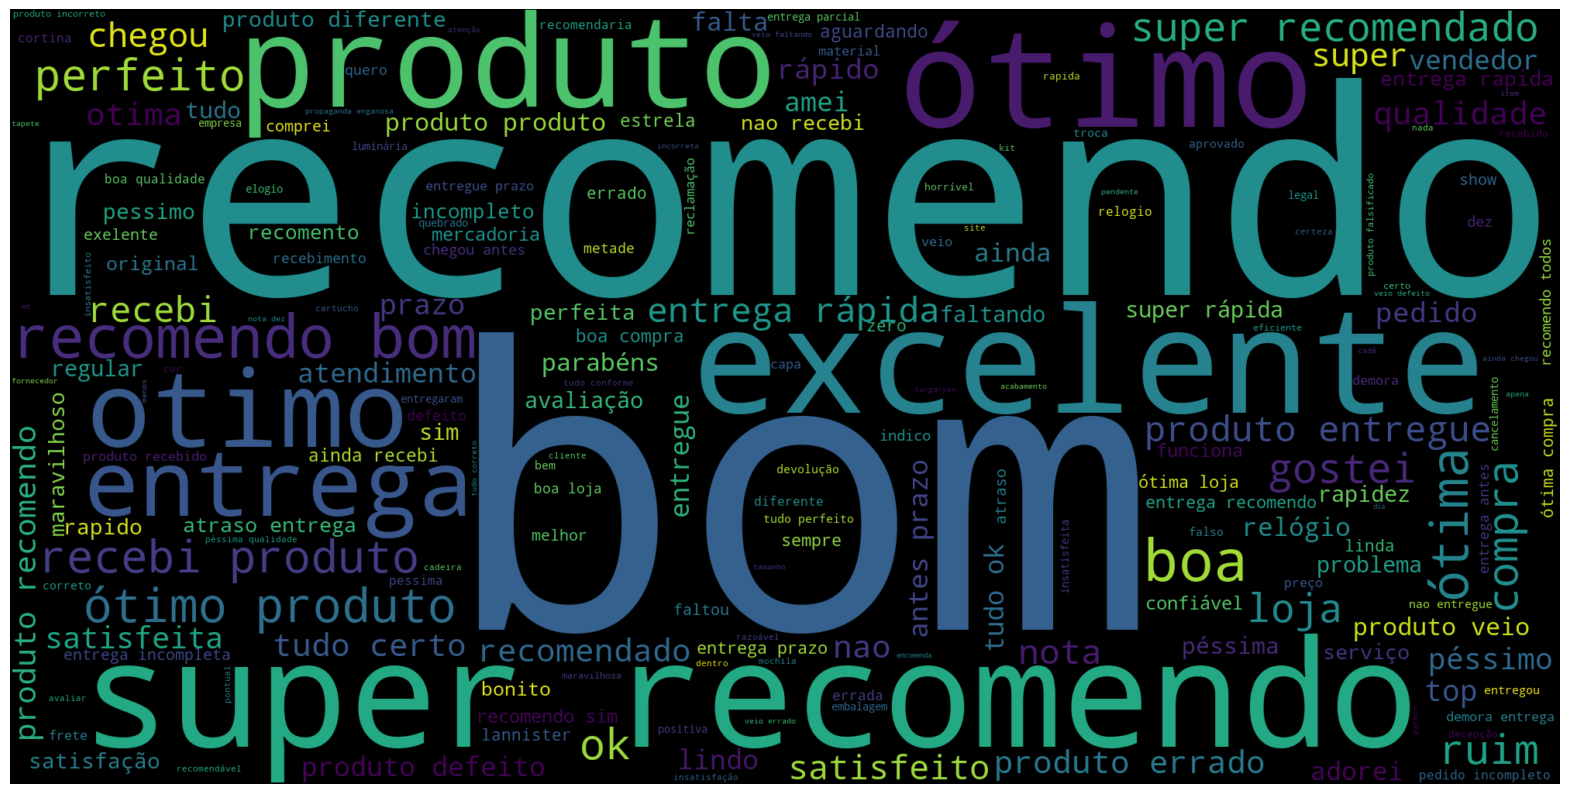

In [30]:
# Usando wordcloud para visualizar o título das avaliações
unique_string= (' ').join(comments_titles)
wordcloud = WordCloud(width=2000, height=1000).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [31]:
# Usando o CountVectorizer para obter os unigramas mais importantes
cv = CountVectorizer(ngram_range=(1,1))
counts = cv.fit_transform(comments_titles)
important_unigrams_title = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)

In [32]:
important_unigrams_title = important_unigrams_title.reset_index()
important_unigrams_title.rename(columns = {'index':'unigrams_title', 0:'frequency'}, inplace=True)

important_unigrams_title.head()

,unigrams_title,frequency
0,recomendo,2071
1,bom,1315
2,produto,1290
3,super,896
4,ótimo,725


In [33]:
# Usando o CountVectorizer para obter os trigramas mais importantes
cv = CountVectorizer(ngram_range=(3,3))
counts = cv.fit_transform(comments_titles)
important_trigrams_title = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)

In [34]:
important_trigrams_title = important_trigrams_title.reset_index()
important_trigrams_title.rename(columns = {'index':'trigrams_title', 0:'frequency'}, inplace=True)
important_trigrams_title.head()

,trigrams_title,frequency
0,entrega super rápida,27
1,entrega antes prazo,15
2,chegou antes prazo,11
3,nao recebi produto,11
4,produto entregue prazo,8


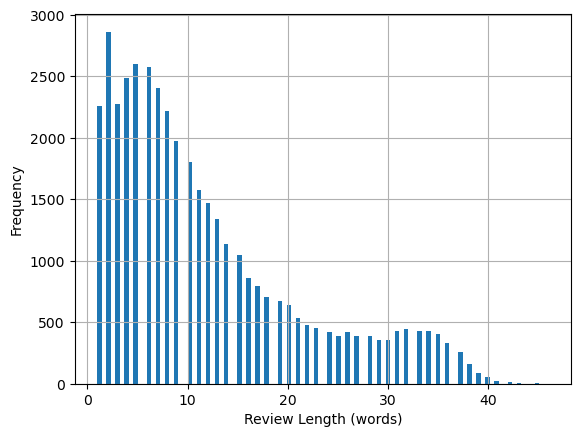

In [35]:
# Analisando a quantidade de palavras por comentário
# A maioria dos comentários tem até no máximo 10 palavras, com pico no intervalo 2-5 palavras
words_per_review = review_data.review_comment_message.apply(lambda x: len(x.split(' ')))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show();

In [36]:
print('Average words:', words_per_review.mean())
print('Skew:', words_per_review.skew())

Average words: 11.81687287990824
Skew: 1.0980395858627507


#### Conclusões
1. A maioria dos comentários tem até no máximo 10 palavras, com pico no intervalo 2-5 palavras
2. Como vimos nos trigramas, 3 palavras já são suficientes para entender o sentimento do cliente. Seria interessante, na seção de avaliações, pedir um texto resumo, até 5 palavras por exemplo, para estimar o cliente a deixar um comentário, mesmo que curto.

### Criando a Máquina Preditiva
Vamos criar uma nova coluna representando a pontuação de sentimento (0 para negativo e 1 para positivo). Excluiremos as avaliações de 3 pontos porque representam avaliação neutra. Incluiremos as pontuações 1 e 2 como palavras negativas e as pontuadas 4 e 5 na revisão de palavras positivas.

In [38]:
# Mapeando os ratings
#se score > 3 = 1 (positivo), senão 0 (negativo)
review_data['Sentiment_ranting'] = np.where(review_data.review_score > 3,1,0)

# Removendo avaliações neutras, selecionando apenas valores diferentes de 3
review_data = review_data[review_data.review_score != 3]

# Exibindo a contagem de cada classificação
review_data['Sentiment_ranting'].value_counts()

Sentiment_ranting
1    26530
0    10890
Name: count, dtype: int64

In [39]:
# Verificando dados após remoção de avaliações neutras
review_data.head()
review_data['Sentiment_ranting'].shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,Sentiment_ranting
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1


(37420,)

In [40]:
# Pré-processando os dados para incluir no modelo
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    comments.append(' '.join(filtered_result))

In [42]:
stopwords_pt = stopwords.words('portuguese')

cv_counts = CountVectorizer(stop_words = stopwords_pt, ngram_range =(1,4))
cv_data = cv_counts.fit_transform(comments)
cv_data

<37420x395245 sparse matrix of type '<class 'numpy.int64'>'
	with 805442 stored elements in Compressed Sparse Row format>

In [43]:
# Separando dados em treino e teste
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(cv_data, review_data['Sentiment_ranting'], test_size = 0.2, random_state=7)

In [44]:
# 70% sentiments = positive; 30% sentiments = negative
y_test_cv.value_counts()/y_test_cv.shape[0]

Sentiment_ranting
1    0.710449
0    0.289551
Name: count, dtype: float64

In [45]:
# Definindo o modelo de treino e teste
lr_model = LogisticRegression()
lr_model.fit(X_train_cv, y_train_cv)

LogisticRegression()

### Avaliação do Modelo
Vamos avaliar a acurácia, F1 Score e Confusion Matrix do nosso modelo. Dada a avaliação, temos que:
- **Acurácia:** Quase 93% de acurácia
- **F1 Score:** 95%
- **Confusion Matrix:** Maior possibilidade de erros ao confundir frases negativas como positivas

In [46]:
### Avaliação do modelo
test_pred = lr_model.predict(X_test_cv)

print('Acurácia:', accuracy_score(y_test_cv, test_pred))
print('F1 Score:', f1_score(y_test_cv, test_pred))
print('Confusion Matrix:', confusion_matrix(y_test_cv, test_pred))

Acurácia: 0.9285141635489044
F1 Score: 0.9500606739475403
Confusion Matrix: [[1860  307]
 [ 228 5089]]


In [47]:
# Peso das palavras no modelo de Regressão Logística
lr_weights = pd.DataFrame(list(zip(cv_counts.get_feature_names_out(),
                                  lr_model.coef_[0])),
                         columns = ['words', 'weights'])

In [48]:
# Avaliações positivas -> palavras com maior peso, puxam para sentimento positivo
Positive_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[:15])
Positive_sentiments.head(20)

,words,weights
153875,excelente,3.144695
393262,ótimo,3.060927
236911,otimo,2.820778
334188,rápido,2.721852
16310,amei,2.659110
42708,bom,2.643586
252547,perfeito,2.485420
200086,lindo,2.459206
333157,rápida,2.404384
232260,obrigada,2.391704


In [49]:
# Avaliações negativas -> palavras com menor peso, mais puxam para sentimento negativo
Negative_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[-15:])
Negative_sentiments.head(20)

,words,weights
103553,demorando,-1.616844
137429,entregaram,-1.638717
102949,demora,-1.641440
254276,pessimo,-1.671658
315177,recebi,-1.680949
245702,passou,-1.715257
144258,enviaram,-1.718507
31555,atrasada,-1.724120
309063,quebrado,-1.800707
188743,insatisfeita,-1.815598


In [58]:
# Testando modelo com avaliação
nova_frase = ["Produto veio com defeito"]

# transforme a frase com o mesmo CountVectorizer usado no treino
nova_frase_cv = cv_counts.transform(nova_frase)

# previsão com o modelo trein ado
predicao = lr_model.predict(nova_frase_cv)

# resultado
print("Predição:", "Positiva" if predicao[0] == 1 else "Negativa")

Predição: Negativa


In [59]:
# Salva o modelo e o vetor de contagem
joblib.dump(lr_model, 'modelo_logistico.pkl')
joblib.dump(cv_counts, 'vetor_countvectorizer.pkl')

['modelo_logistico.pkl']

['vetor_countvectorizer.pkl']